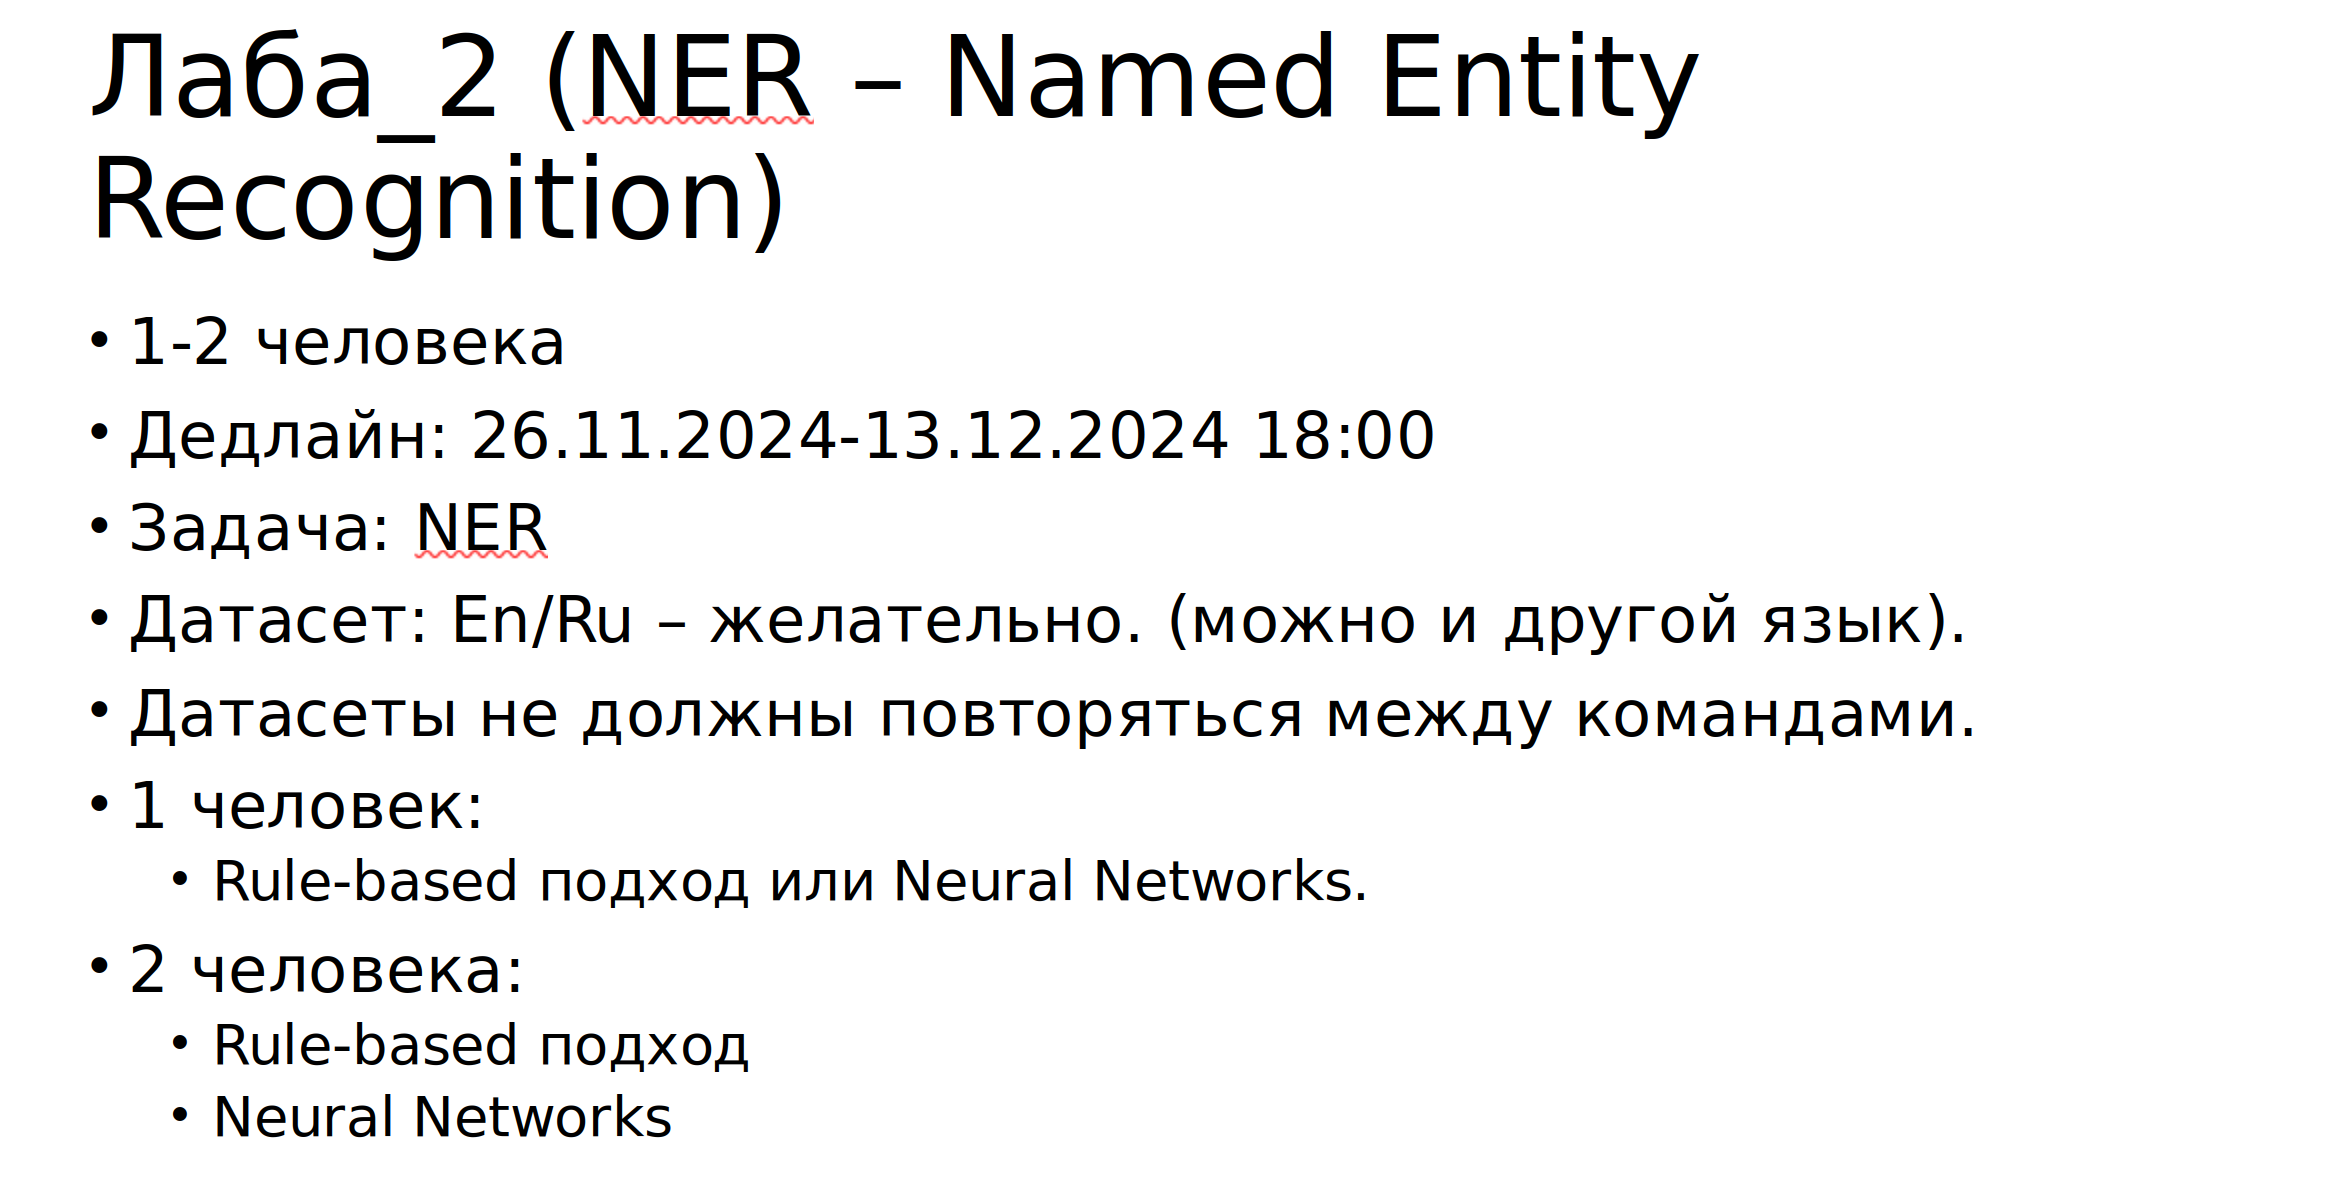

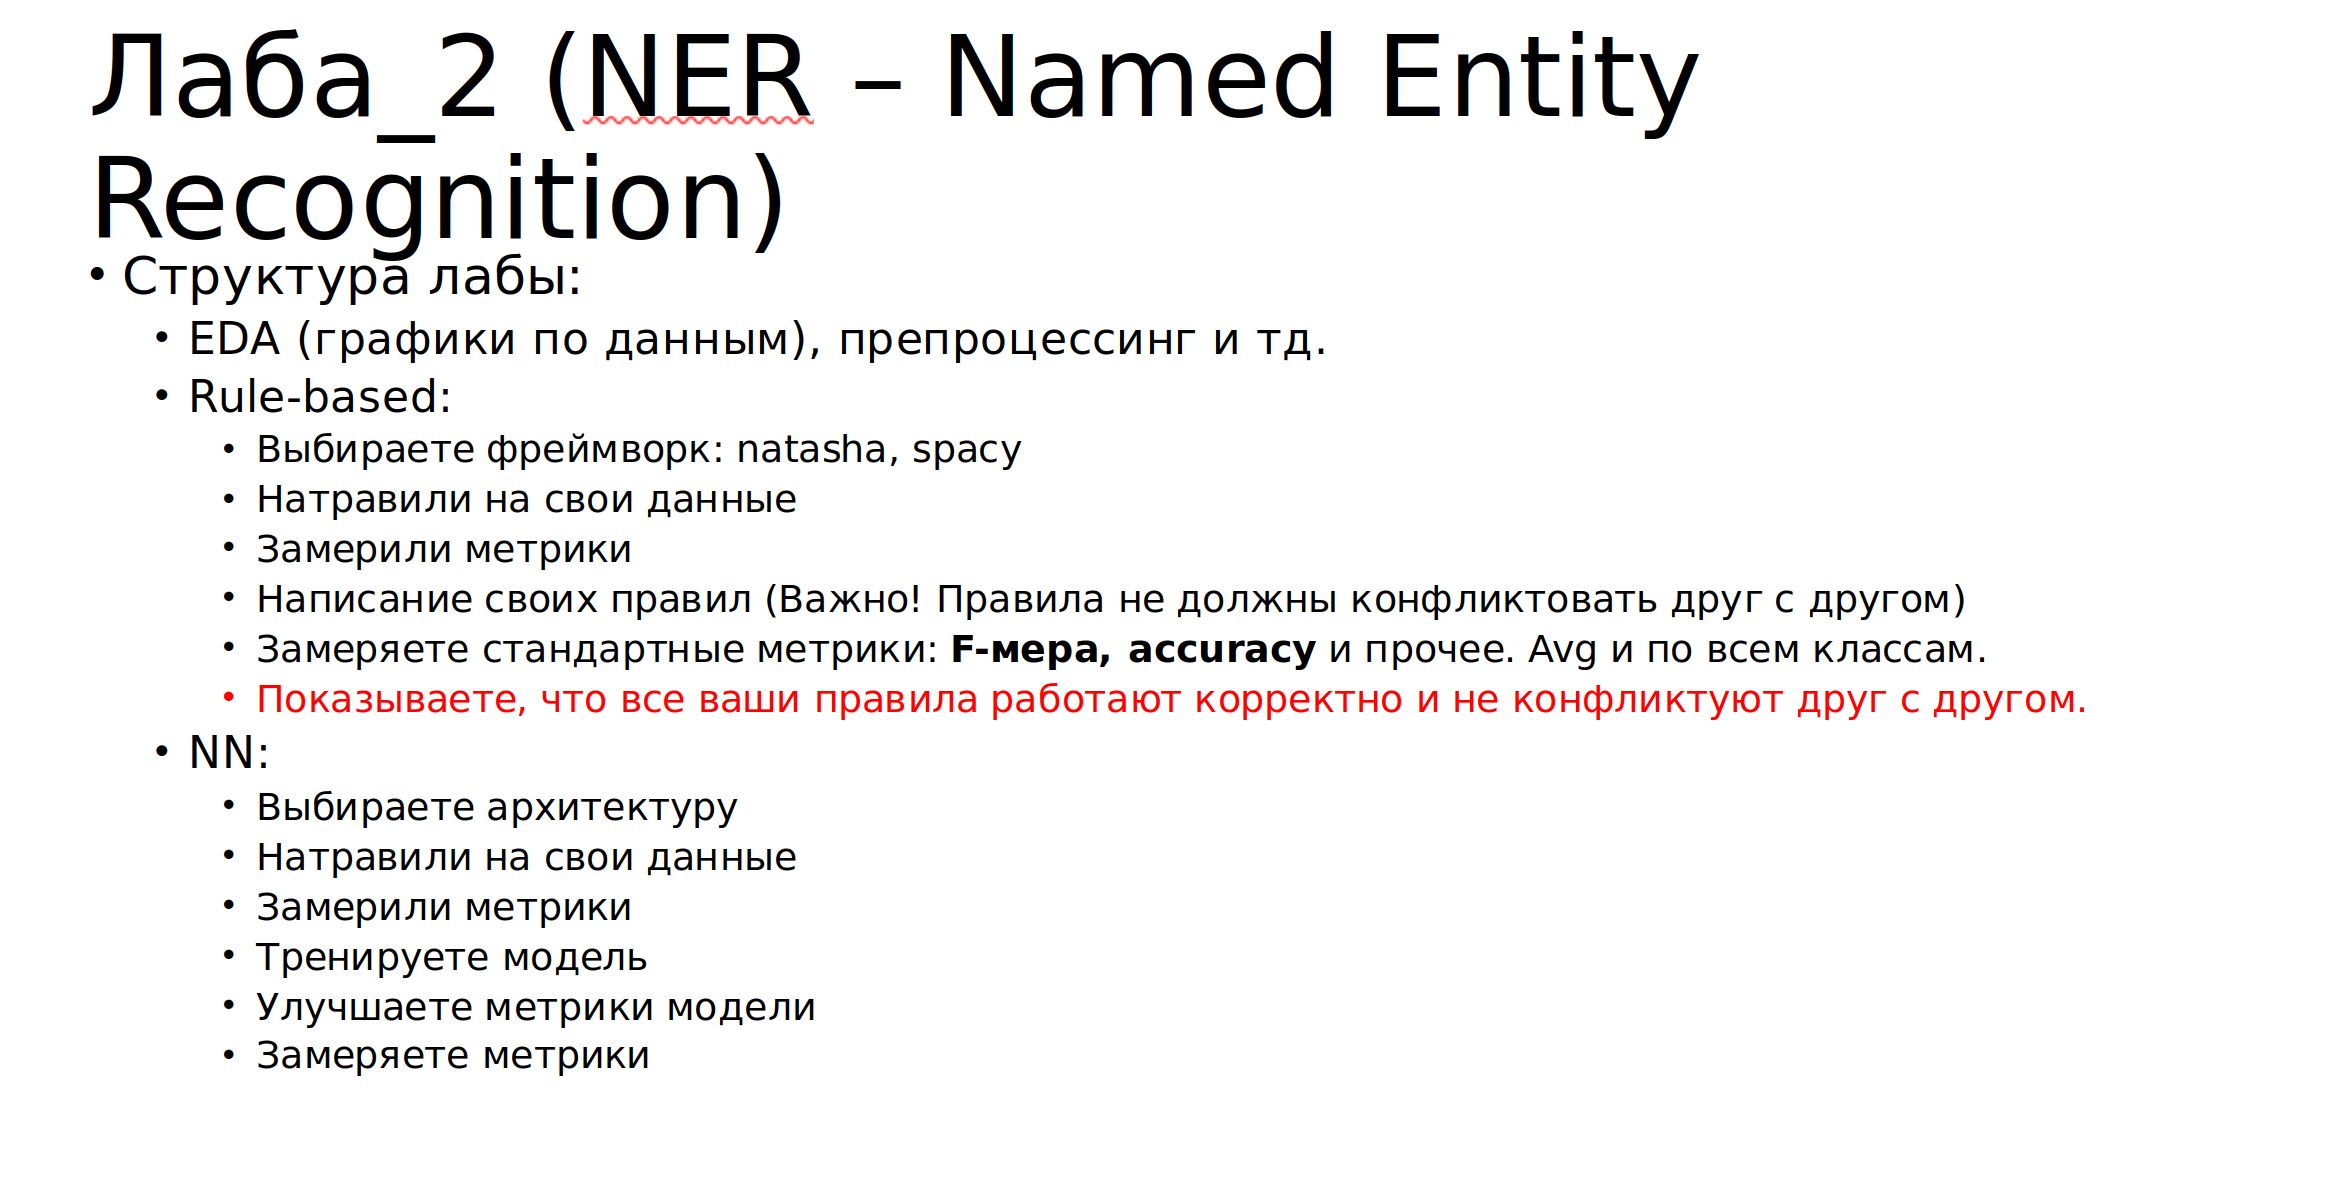

## Данные

[Ссылка на датасет](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data)

Выбранный датасет содержит около 140000 предложений, взятых из статей англоязычной википедии.

In [1]:
import pandas as pd
import numpy as np

file = './data/wikiner.txt'
with open(file, 'r') as f:
    file = f.readlines()

data = []
data_dict = {}
for line in file:
    try:
        ind, word, label = line.split()
    except:
        continue
    if ind == '0':
        data.append(data_dict)
        data_dict = {'tokens': [word], 'labels': [label]}
    else:
        data_dict['tokens'].append(word)
        data_dict['labels'].append(label)


data = pd.DataFrame(data[1:])
data.head()

,tokens,labels
0,"[The, Oxford, Companion, to, Philosophy, says,...","[B-MISC, I-MISC, I-MISC, I-MISC, I-MISC, O, O,..."
1,"[In, the, end, ,, for, anarchist, historian, D...","[O, O, O, O, O, O, O, B-PER, I-PER, O, O, O, O..."
2,"[From, this, climate, William, Godwin, develop...","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O..."
3,"[Godwin, was, ,, according, to, Peter, Kropotk...","[B-PER, O, O, O, O, B-PER, I-PER, O, O, O, O, ..."
4,"[Its, classical, period, ,, which, scholars, d...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [2]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=42)

train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)
print(f'Train size: {train_data.shape[0]}')
print(f'Test size: {test_data.shape[0]}')

train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)

Train size: 108255
Test size: 36086


In [3]:
from ast import literal_eval
import pandas as pd

converter = {'tokens': literal_eval, 'labels': literal_eval}
train_data = pd.read_csv('./data/train.csv', converters=converter)
test_data = pd.read_csv('./data/test.csv', converters=converter)

В данных представлена разметка. Каждому токену присвоен лейбл: О если токен не является частью именованной сущности, В если с этого токена начинается подпоследовательность именованной сущности, I - если токен принадлежит подпоследовательности именованной сущности.

Дополнительно лейблы I и B классифицированы на следующие классы:

* PER - Человек
* ORG - Организация
* LOC - Место
* MISC - именованная сущность, не пренадлежащая какой-либо из вышеописанных категорий (событие, произведение искусства и т.д.)


Посмотрим на разметку глазами:

In [4]:
import random

num_examples = 5
for document in range(num_examples):
  # beginning = random.randint(0, len(train_data.tokens[document]) - 16)
  beginning = 0
  ending = beginning + 20

  print(f'Document {document}, tokens from {beginning} to {ending}:')
  print(
      pd.DataFrame(
          {
              'tokens:': train_data.tokens[document][beginning:ending],
              'labels:': train_data.labels[document][beginning:ending]
          }
      )
      .transpose()
      .to_string(index=True, header=False),
      '\n'
  )


Document 0, tokens from 0 to 20:
tokens:  Agrippina    the  Younger  has  been  described  by  both  the  ancient  and  modern  sources  as  '  ruthless  ,  ambitious  ,  violent
labels:      B-PER  I-PER    I-PER    O     O          O   O     O    O        O    O       O        O   O  O         O  O          O  O        O 

Document 1, tokens from 0 to 20:
tokens:  Nature  defended  its  story  and  declined  to  retract  ,  stating  that  ,  as  it  was  comparing  Wikipedia  with  the  web
labels:  B-MISC         O    O      O    O         O   O        O  O        O     O  O   O   O    O          O     B-MISC     O    O    O 

Document 2, tokens from 0 to 20:
tokens:  The   Gaza  Strip  has  a  small  ,  poorly  developed  road  network  .
labels:    O  B-LOC  I-LOC    O  O      O  O       O          O     O        O  O 

Document 3, tokens from 0 to 20:
tokens:  Other  parts  of  the  society  's  land  were  acquired  by  the  American  Bridge  Company  to  expand  the  town  of  

Посмотрим на примеры категорий:

In [5]:
labels_list = ['ORG', 'PER', 'LOC', 'MISC']
labels = set([
    label.split('-')[-1]
    for annot in train_data.labels
    for label in annot
]) - {'O'}


def get_examples(label: str, num_examples: int):
  examples = []
  for document in range(0, train_data.shape[0]):
    if len(examples) >= num_examples:
      return examples
    try:
      beginning = train_data.labels[document].index(f'B-{label}')
    except ValueError:
      continue

    example = train_data.tokens[document][beginning].strip()
    for token_id in range(beginning + 1, len(train_data.tokens[document]) - 1):
      if train_data.labels[document][token_id] == f'I-{label}':
        example += ' ' + train_data.tokens[document][token_id].strip()
    examples.append(example)

  print(f'WARNING: could not find {num_examples} examples for label {label}, found {len(examples)} examples')
  return examples


label_examples = {}
for label in labels:
  label_examples[label] = get_examples(label=label, num_examples=10)

In [6]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in label_examples.items()])).T

,0,1,2,3,4,5,6,7,8,9
ORG,American Bridge Company,Liberal Party,News Chronicle,Houston,Tammany Hall,San Francisco State College,Hunter,Freeview,8th Air Force,Durham
LOC,Gaza Strip,Ambridge,Tibur Hills,Lake District National Park,Elstree,Ballarat Line railway station,Iraq,Greece,New York,Broadway River Bridge Hill Bronx Cortlandt Park
PER,Agrippina the Younger,Chopin,Charles II,Hadrian,Augustine,Louis Theroux,Ceolfrith,Paul VI,John Russell,Steiner
MISC,Nature,Eastern Orthodox Church,Welsh,Keep the Aspidistra Flying,Republican,A Pattern Language,CH-46,Godzilla vs. Biollante,Veronica Mars,World War II Liberator


## EDA

### Какова длина предложений?

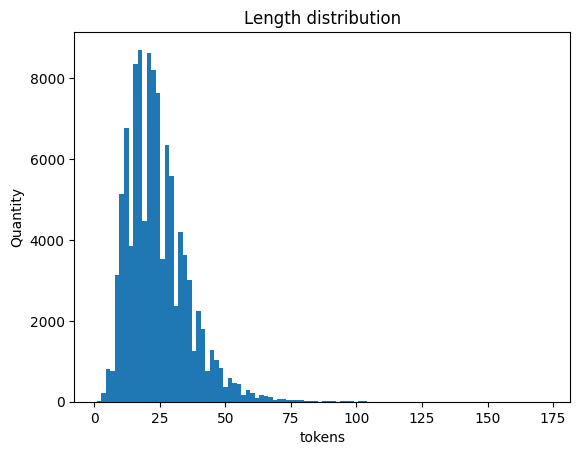

In [7]:
train_data.tokens.apply(len).plot.hist(title='Length distribution', xlabel='tokens', ylabel='Quantity', bins=100);

### Как часто встречаются NE?

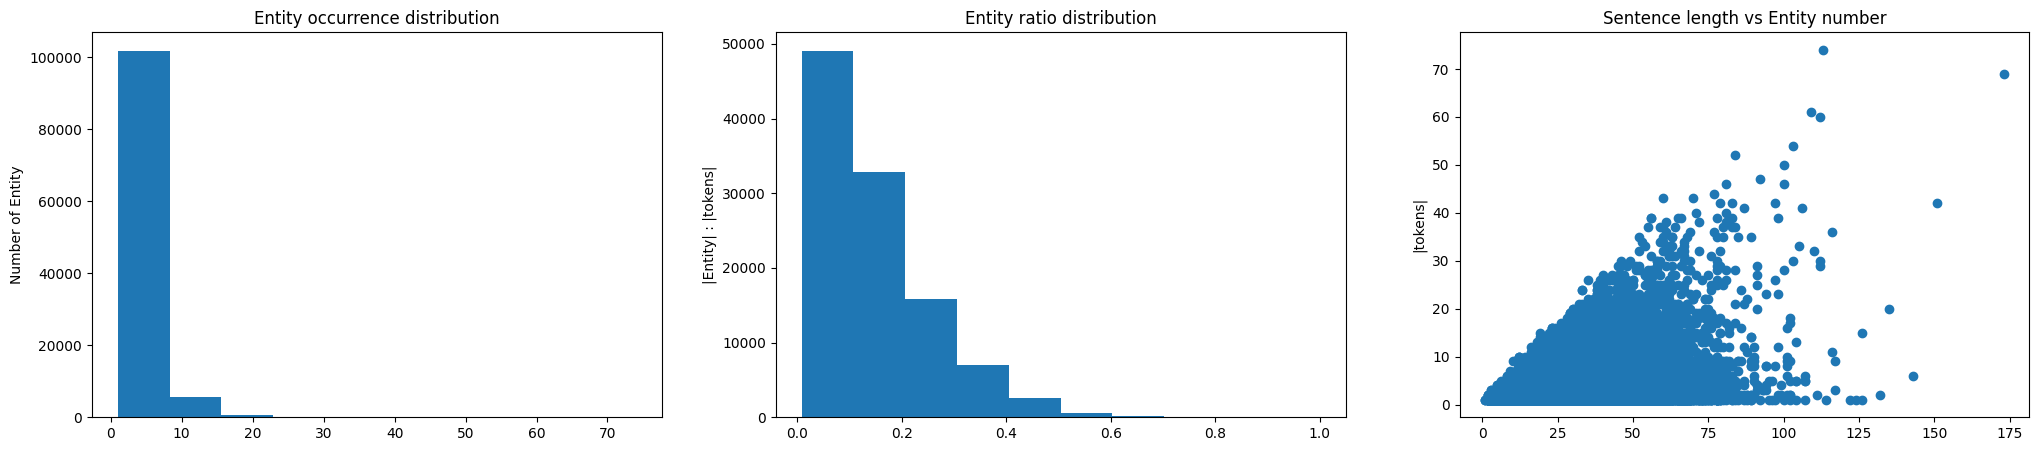

In [8]:
from matplotlib import pyplot as plt

non_pii_count = train_data.labels.apply(lambda x: x.count('O'))
pii_count = train_data.labels.apply(len) - non_pii_count
pii_ratio = pii_count / train_data.labels.apply(len)


fig, axes = plt.subplots(1, 3, figsize=(25, 5))
axes[0].hist(pii_count)
axes[0].set_title('Entity occurrence distribution')
axes[0].set_ylabel('Number of Entity')

axes[1].hist(pii_ratio)
axes[1].set_title('Entity ratio distribution')
axes[1].set_ylabel('|Entity| : |tokens|')

axes[2].scatter(train_data.labels.apply(len), pii_count)
axes[2].set_title('Sentence length vs Entity number')
axes[2].set_ylabel('|Entity|')
axes[2].set_ylabel('|tokens|')

plt.show()

In [9]:
print('Среднее количество сущностей в тексте:', pii_count.mean(), 'Максимальное количество: ', pii_count.max())

Среднее количество сущностей в тексте: 3.3754376241282156 Максимальное количество:  74


In [10]:
print('Коэффициент корреляции длины и кол-ва NE:', np.corrcoef(pii_count, train_data.labels.apply(len))[0, 1])

Коэффициент корреляции длины и кол-ва NE: 0.38642485300249113


В целом, интересующие категории встречаются не очень часто: в среднем меньше пяти раз, при этом максимальное наблюдаемое количество -- 74. Они как правило составляют менее 10 процентов от общего текста.

Присутствует небольшая положительная корреляция между количеством сущностей и длиной предложения, что вполне логично.

### Распределение категорий

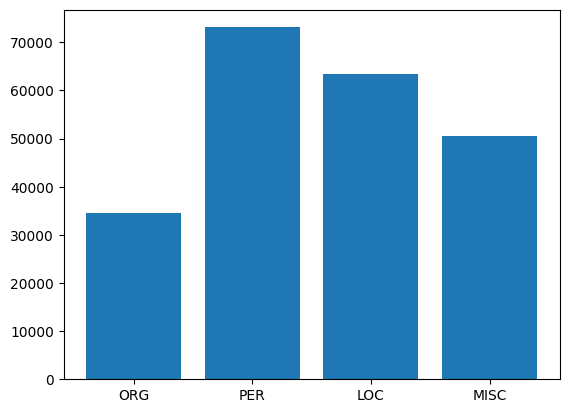

In [11]:
from src.visualisation import plot_categ_distribution


plot_categ_distribution(train_data)

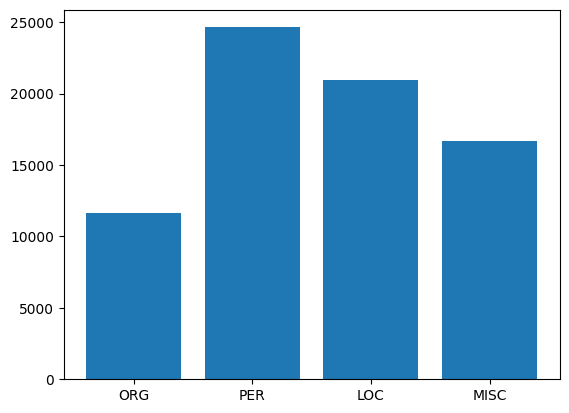

In [12]:
plot_categ_distribution(test_data)

Как можно видеть, меньше всего в датасете представлено организаций, больше всего - персон. Распределение в тренировочной и тестовой выборке  совпадают.  
Остальные именованные сущности (MISC) тоже представлены меньше, по сравнению с остальными. Если учесть что они сами являются примерами из различных категорий, с их идентифицированием могут возникнуть проблемы, так как их отдельные виды могут быть слабо представлены.

Дополнительно рассмотрим, какие категории встречаются чаще в одном и том же предложении.

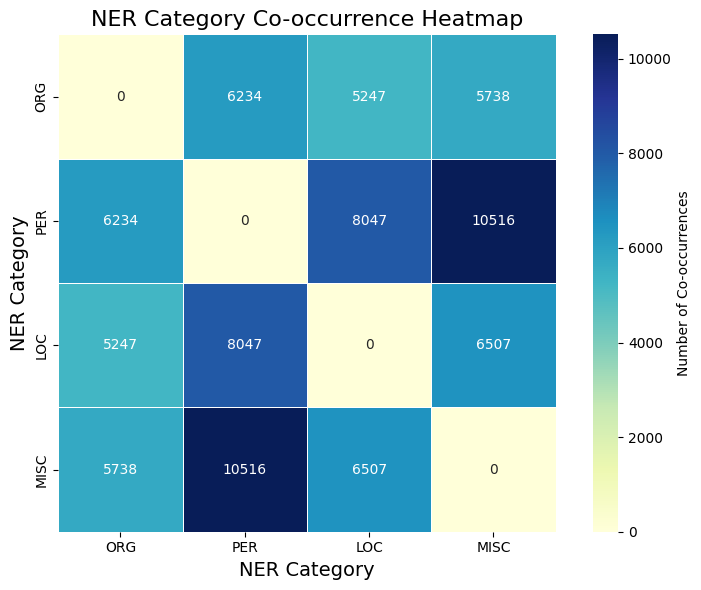

In [13]:
from src.visualisation import plot_cooccurrence

plot_cooccurrence(train_data)

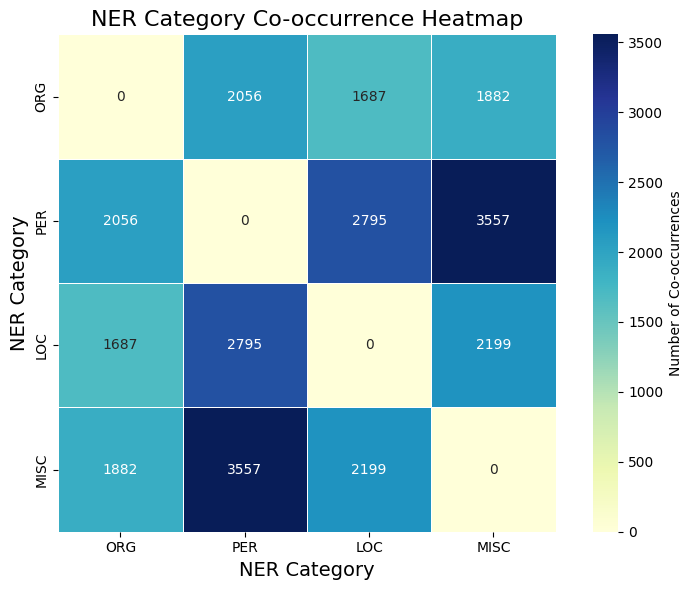

In [14]:
plot_cooccurrence(test_data)

## Spacy и rule-based подход

### Оценка стартового качества

Модель SpaCy `en_core_web_sm` поддерживает классификацию NER на следующие категории:

* CARDINAL - Numerals that do not fall under another type.
* DATE -  Absolute or relative dates or periods.
* EVENT - Named hurricanes, battles, wars, sports events, etc.
* FAC - Buildings, airports, highways, bridges, etc.
* GPE - Countries, cities, states.
* LANGUAGE - Any named language.
* LAW - Named documents made into laws.
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* MONEY - Monetary values, including unit.
* NORP - Nationalities or religious or political groups.
* ORDINAL - "first", "second", etc.
* ORG - Companies, agencies, institutions, etc.
* PERCENT - Percentage, including "%".
* PERSON - People, including fictional.
* PRODUCT - Objects, vehicles, foods, etc. (Not services.)
* QUANTITY - Measurements, as of weight or distance.
* TIME - Times smaller than a day.
* WORK_OF_ART - Titles of books, songs, etc.

In [15]:
from ast import literal_eval

converter = {'tokens': literal_eval, 'labels': literal_eval}

train_data = pd.read_csv('./data/train.csv', converters=converter)
test_data = pd.read_csv('./data/test.csv', converters=converter)

In [16]:
! pip install evaluate seqeval -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import spacy
from spacy.tokens import Doc, DocBin
import evaluate
from tqdm import tqdm
from src.spacy_utils import convert_tag, calculate_metrics, compute_spacy_metrics, make_docs, load_docs
tqdm.pandas()

metric = evaluate.load("seqeval")
nlp = spacy.load("en_core_web_sm")

D:\Учёба\Мага\NLP_HW2\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
#make_docs(test_data, nlp, 'test_doc.bin')
#make_docs(train_data, nlp, 'train_doc.bin')

In [19]:
test_preds = load_docs('test_doc.bin', nlp)
train_preds = load_docs('train_doc.bin', nlp)

### Частеречная характеристика категорий

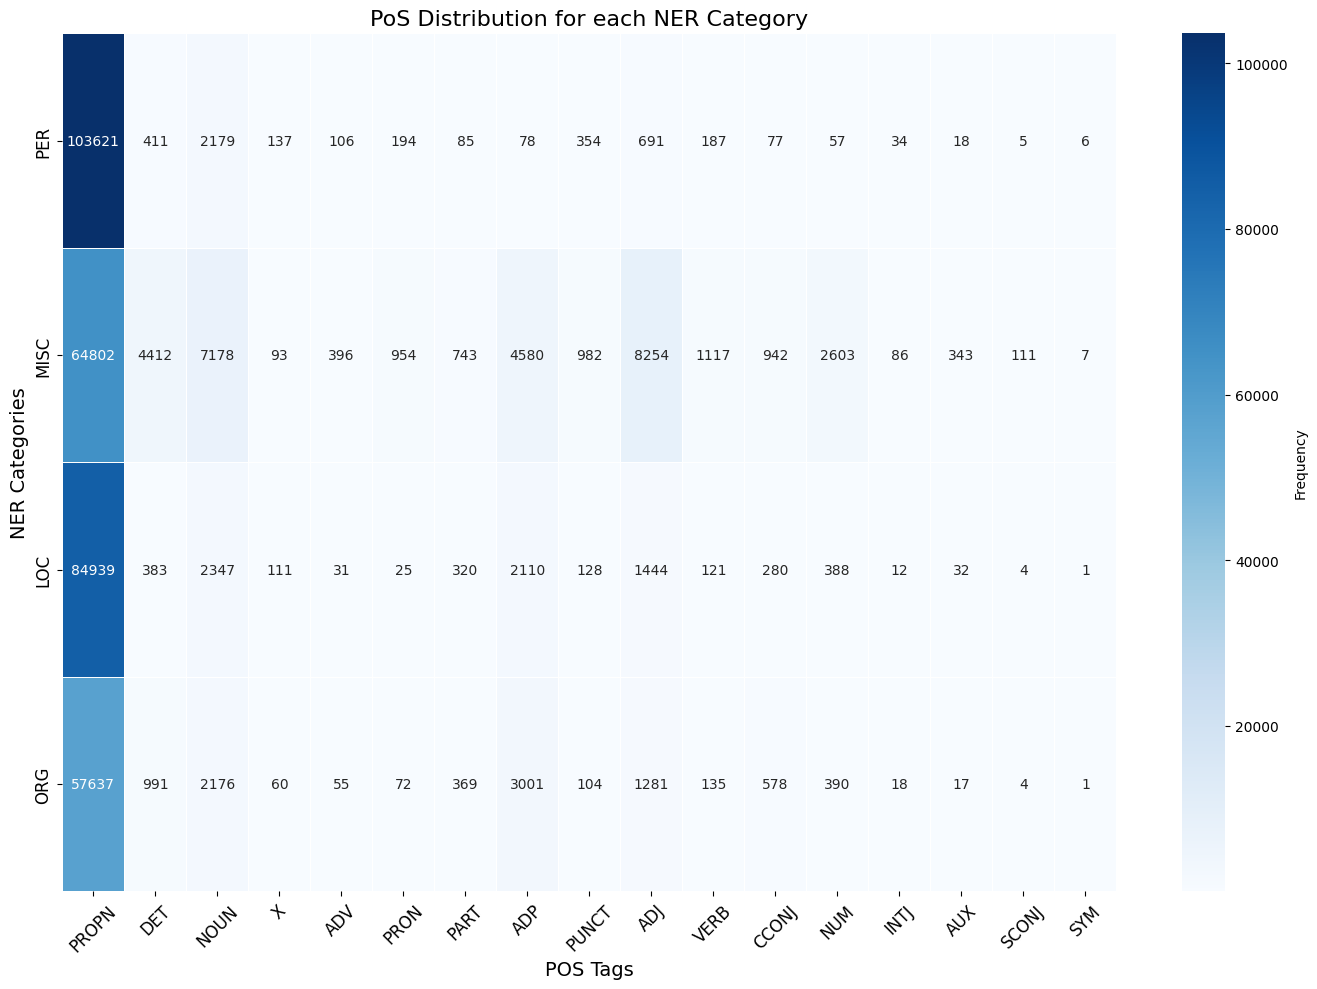

In [20]:
from src.spacy_utils import extract_pos_distribution, visualize_pos_distribution


train_pos_distr = extract_pos_distribution(train_data, train_preds)
visualize_pos_distribution(train_pos_distr)

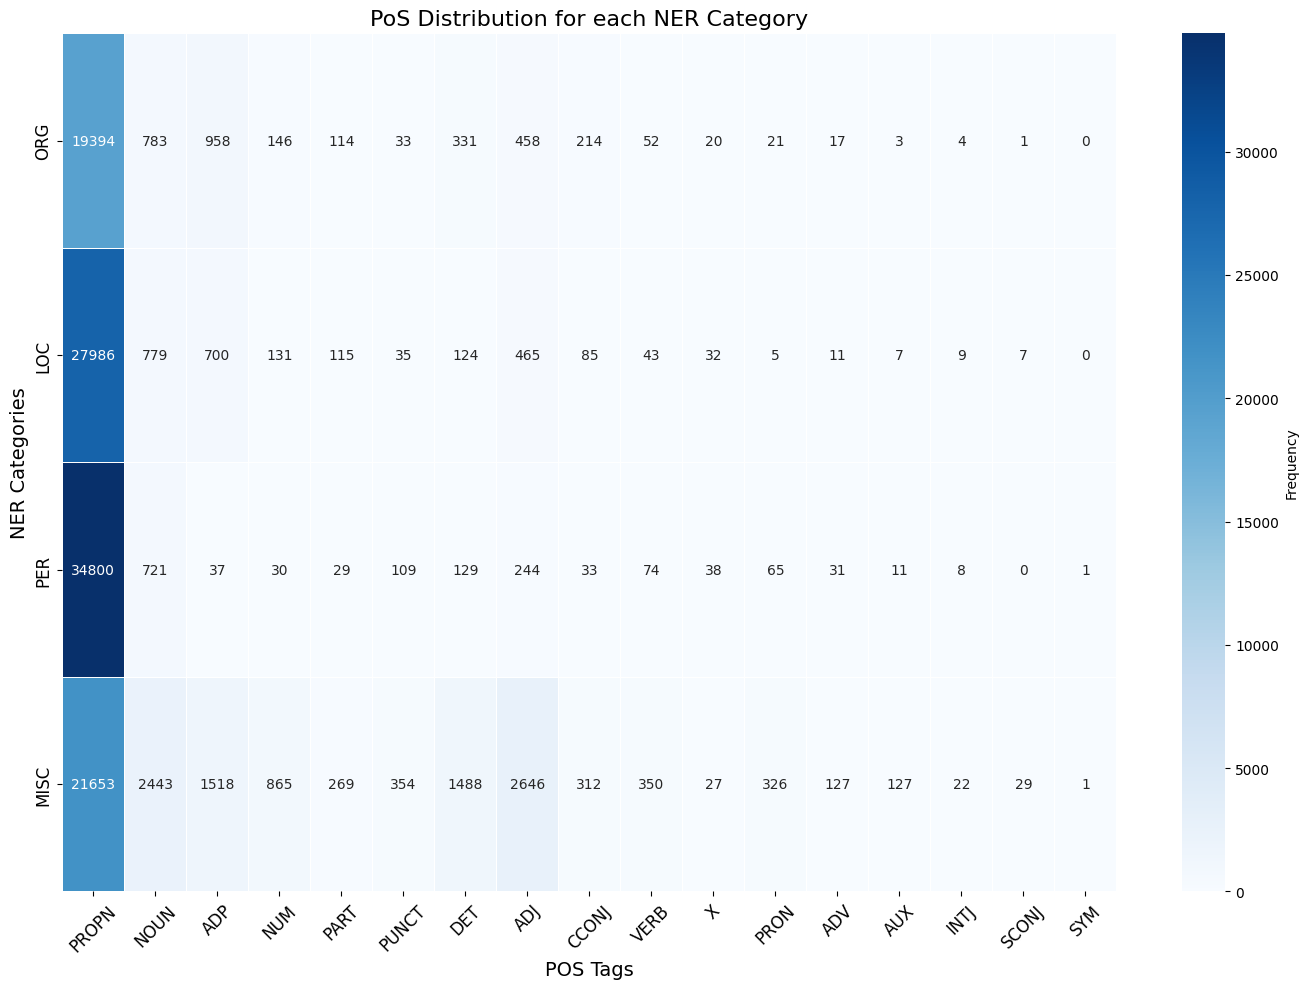

In [21]:
test_pos_distr = extract_pos_distribution(test_data, test_preds)
visualize_pos_distribution(test_pos_distr)

### Подсчёт метрик SpaCy

                    ORG           PER           LOC          MISC
precision      0.254696      0.693015      0.632557      0.415365
recall         0.445713      0.564348      0.555709      0.075961
f1             0.324157      0.622098      0.591648      0.128435
number     11651.000000  24717.000000  20957.000000  16798.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.517161        0.432578    0.471103          0.915453


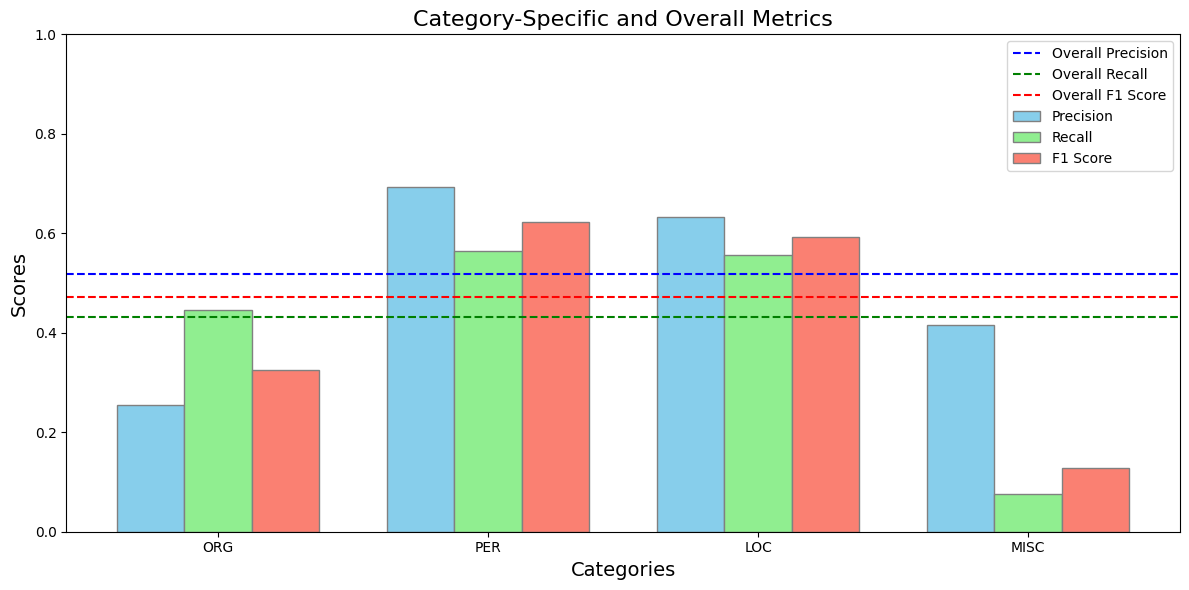

In [22]:
from src.visualisation import visualize_metrics


test_metrics = compute_spacy_metrics(test_preds, test_data['labels'], metric)
visualize_metrics(*test_metrics)

                    ORG           PER           LOC          MISC
precision      0.251425      0.691873      0.636034      0.414783
recall         0.442699      0.564469      0.560556      0.078948
f1             0.320709      0.621711      0.595914      0.132648
number     34764.000000  73361.000000  63487.000000  50679.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.516383        0.433616    0.471394          0.915874


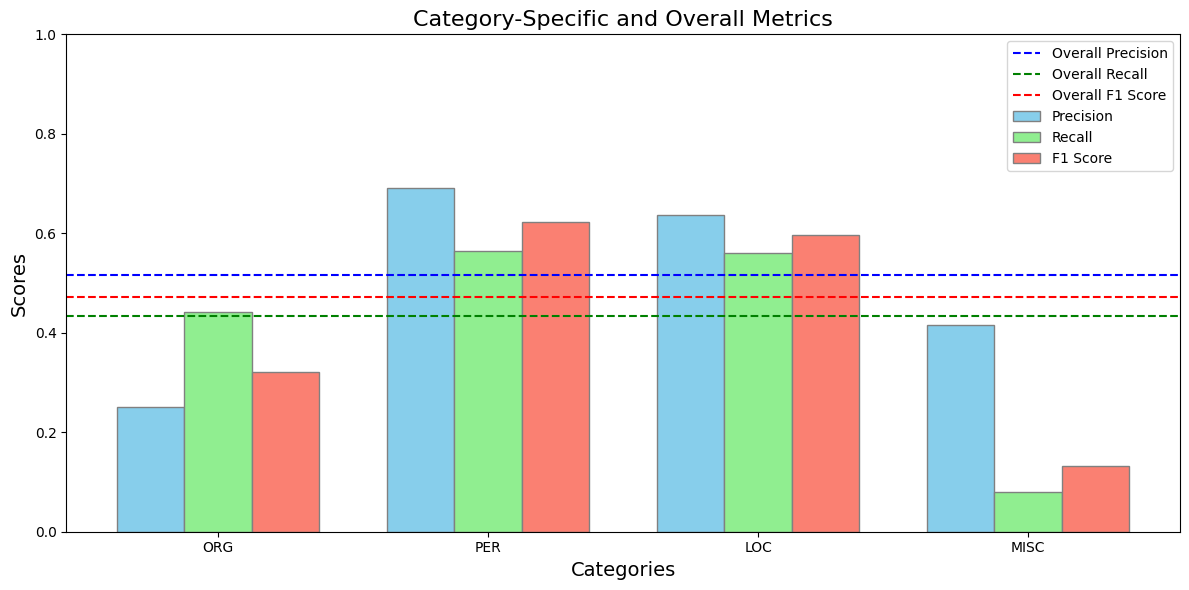

In [23]:
train_metrics = compute_spacy_metrics(train_preds, train_data['labels'], metric)
visualize_metrics(*train_metrics)

Как и ожидалось, категория MISC имеет самые худшие метрики. Особенно плох recall, так как модели тяжело детектировать различные слабо представленные сущности, не имеющие общих черт. Лучше всего предсказываются персоны и локации, имена довольно легко выделяютя из общей массы слов. Наименования организаций тоже сложная цель для модели, так как они могут состоять из нескольких слов, многие из которых нельзя назвать именованными сущностями в отрыве от контекста, а также многие названия компаний являются обычными словами.  
Стоит отметить огромную разницу между F1 и accuracy, что в совокупности с низким recall сразу по всем классам говорит нам, что модель просто не замечает огромную часть именованных сущностей, не относя их ни к какому классу. Огромный вклад в accuracy вносят правильно определённые background токены, вот почему она такая высокая.

### Error analysis

In [24]:
from src.spacy_utils import extract_predictions, error_example

In [25]:
train_data = extract_predictions(train_data, train_preds)
test_data = extract_predictions(test_data, test_preds)

for category in labels_list:
  error_example(train_data, category, n_examples=2)

Unrecognized ORG entities:

tokens:  Houston  lost          10  --           3  but  it  was  a  glimpse  of  what  was  to  come  in     the    next     few  seasons  .
true  :    B-ORG     O           O   O           O    O   O    O  O        O   O     O    O   O     O   O       O       O       O        O  O
pred  :    B-LOC     O           O   O           O    O   O    O  O        O   O     O    O   O     O   O       O       O       O        O  O
raw   :    B-GPE     O  B-CARDINAL   O  B-CARDINAL    O   O    O  O        O   O     O    O   O     O   O  B-DATE  I-DATE  I-DATE   I-DATE  O 

tokens:  The  group  was  inspired  by  student-initiated  experimental  schools  ,  especially    San  Francisco  State  College  ,  and  sought  ways  to  improve  education  for  students  at     Brown  .
true  :    O      O    O         O   O                  O             O        O  O           O  B-ORG      I-ORG  I-ORG    I-ORG  O    O       O     O   O        O          O    O         O   O

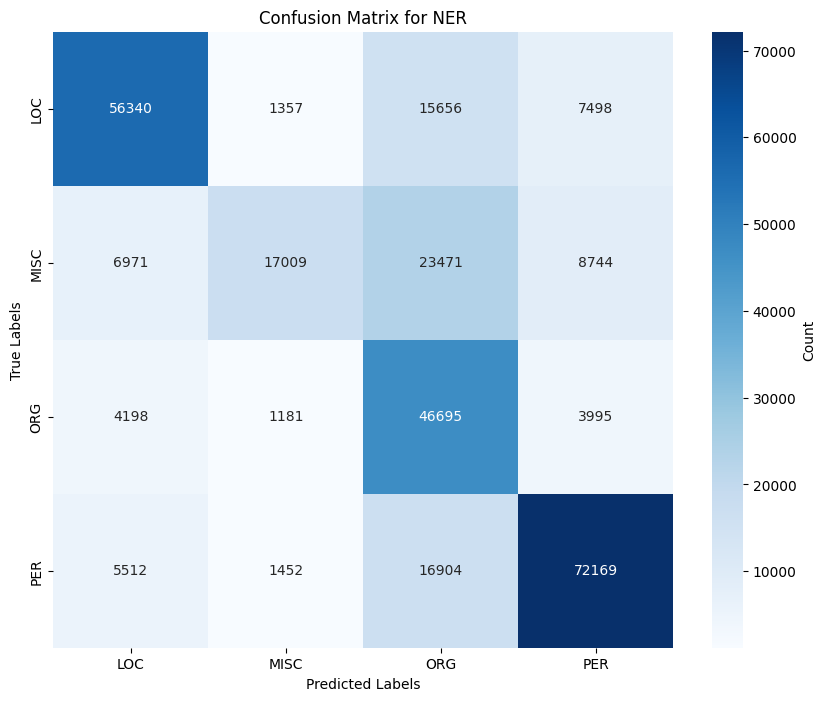

In [26]:
from src.visualisation import draw_confusion_matrix

draw_confusion_matrix(train_data.predictions, train_data.labels)

Многие ошибки завязаны на омонимии:  Brown, Hunter, Houston могут выступать как именами, так и местами/организациями.

Также есть отличия в том, включаются артикли или нет.
Так, сочетания the  United  Kingdom, the  Harlem  River, the  Bronx имеют аннотацию именованной сущности в датасете, тогда как модель помечает токен the как О. Напротив, обратная проблема наблюдается с сочетанием the  Sabine  Hills.

Также ряд ошибок связан с тем, что многие организации содержат в себе географические названия: San  Francisco  State  College. Модель помечает это как LOC, тогда как ожидается ORG.

Попробуем точечно исправить эти ошибки.

### My homework my rules

In [27]:
def get_id_by_string(data: pd.DataFrame, string: str):
    return data[data['tokens'].apply(lambda x: string in x)].index.tolist()


def display_text_prettily(data: pd.DataFrame, instances: int | None = None):
    indices = list(range(len(data))) if instances is None else random.sample(range(len(data)), instances)
    for index in indices:
      print(
        pd.DataFrame(
            {
                'tokens:': data.tokens.iloc[index],
                'true  :': data.labels.iloc[index],
                'old   :': data.predictions.iloc[index],
                'new   :': data.new_predictions.iloc[index]
            }
        )
        .transpose()
        .to_string(index=True, header=False),
        '\n'
    )

In [28]:
error_patterns = [
    'Brown', 'Hunter', 'Houston', 'Nauvoo',
    'Britannica', 'Cascades', 'Centauri', 'Isles',
    'Kingdom', 'Harlem', 'Bronx', 'College'

]
error_samples = []
for error_pattern in error_patterns:
  error_samples.extend(get_id_by_string(train_data, error_pattern))
train_data_error_subset = train_data.loc[error_samples]
print(f'Error focused subset lengths: {train_data_error_subset.shape}')

Error focused subset lengths: (1383, 4)


In [44]:
patterns = [
    {"label": "LOC", "pattern": "Alpha Centauri"},
    {"label": "LOC", "pattern": "Nauvoo"},
    {"label": "LOC", "pattern": "Houston"},
    {"label": "LOC", "pattern": "Mauritius"},
    {"label": "LOC", "pattern": "Columbia"},
    {"label": "LOC", "pattern": "Dartmouth"},
    {"label": "LOC", "pattern": "Croatia"},


    {"label": "LOC", "pattern": "Cascades Rapids"},
    {"label": "LOC", "pattern": "British Isles"},
    {"label": "LOC", "pattern": "Diego  Garcia"},

    {"label": "LOC", "pattern": "the  United  Kingdom"},
    {"label": "LOC", "pattern": "the  Harlem  River"},
    {"label": "LOC", "pattern": "The  Bronx"},

    {"label": "ORG", "pattern": "Hush Hip Hop Tours"},
    {"label": "ORG", "pattern": "The  Hunter  College"},
    {"label": "ORG", "pattern": "San  Francisco  State  College"},
    {"label": "ORG", "pattern": "Houston Post"},

    {"label": "ORG", "pattern": "Brown"},
    {"label": "ORG", "pattern": "Hunter"},
    {"label": "ORG", "pattern": "Houston"},

    {"label": "PER", "pattern": "Auchinleck"},
    {"label": "PER", "pattern": "Clarence  Brown"},

    {"label": "MISC", "pattern": "Encyclopaedia  Britannica"},
    {"label": "MISC", "pattern": "Encyclop?dia  Britannica"},
    {"label": "MISC", "pattern": "Britannica"},
    {"label": "MISC", "pattern": "Wikipedia"},
    {"label": "MISC", "pattern": "Napoleonic wars"},
    {"label": "MISC", "pattern": "battle of Waterloo"},
    {"label": "MISC", "pattern": "Heart of Oak"},

]

nlp = spacy.load("en_core_web_sm")
old_docs = train_data_error_subset['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))

ruler = nlp.add_pipe("entity_ruler", after='ner')
ruler.add_patterns(patterns)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1383/1383 [00:09<00:00, 152.06it/s]

In [30]:
old_docs = train_data_error_subset['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))
new_predictions = list(map(lambda row: [e.ent_iob_ + '-' + e.ent_type_ if e.ent_iob_ != 'O' else 'O' for e in row], old_docs))
train_data_error_subset['new_predictions'] = list(map(lambda row: [convert_tag(e) for e in row], new_predictions))


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1383/1383 [00:08<00:00, 170.99it/s]

In [31]:
calculate_metrics(train_data_error_subset['predictions'].tolist(),
                  train_data_error_subset['labels'].tolist(),
                  metric)
None

                   ORG         PER          LOC        MISC
precision     0.471474    0.574941     0.547763    0.484848
recall        0.499161    0.711594     0.515065    0.100840
f1            0.484923    0.636010     0.530911    0.166957
number     1192.000000  690.000000  1759.000000  476.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.527268        0.495506    0.510894          0.887621


In [32]:
calculate_metrics(train_data_error_subset['new_predictions'].tolist(),
                  train_data_error_subset['labels'].tolist(),
                  metric)
None

                   ORG         PER          LOC        MISC
precision     0.467818    0.574941     0.546988    0.484848
recall        0.500000    0.711594     0.516202    0.100840
f1            0.483374    0.636010     0.531149    0.166957
number     1192.000000  690.000000  1759.000000  476.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.525598        0.496235    0.510495          0.887779


In [33]:
display_text_prettily(train_data_error_subset, instances=10)

tokens:  Imports  --  partners  :  Nigeria  15.2  %  ,    the  People     's  Republic     of  China  12.5  %  ,  United  States  6.3  %  ,  United  Kingdom  5.23  %  ,  South  Africa  4.5  %  ,  Brazil  4.1  %  ,  Netherlands  4.0  %  (  2005  )
true  :        O   O         O  O    B-LOC     O  O  O      O   B-LOC  I-LOC     I-LOC  I-LOC  I-LOC     O  O  O   B-LOC   I-LOC    O  O  O   B-LOC    I-LOC     O  O  O  B-LOC   I-LOC    O  O  O   B-LOC    O  O  O        B-LOC    O  O  O     O  O
old   :        O   O         O  O        O     O  O  O  B-LOC   I-LOC  I-LOC     I-LOC  I-LOC  I-LOC     O  O  O   B-LOC   I-LOC    O  O  O   B-LOC    I-LOC     O  O  O  B-LOC   I-LOC    O  O  O   B-LOC    O  O  O        B-LOC    O  O  O     O  O
new   :        O   O         O  O        O     O  O  O  B-LOC   I-LOC  I-LOC     I-LOC  I-LOC  I-LOC     O  O  O   B-LOC   I-LOC    O  O  O   B-LOC    I-LOC     O  O  O  B-LOC   I-LOC    O  O  O   B-LOC    O  O  O        B-LOC    O  O  O     O  O 

tokens:  T

In [45]:
from spacy.tokens import Span
from spacy.language import Language

@Language.component("include_articles_entities")
def expand_person_entities(doc):
    new_ents = []
    for ent in doc.ents:
        if ent.label_ in {"LOC", "ORG", "MISC", "GPE", "FAC"} and ent.start != 0:
            prev_token = doc[ent.start - 1]
            if prev_token.lower_ == 'the':
                new_ent = Span(doc, ent.start - 1, ent.end, label=ent.label)
                new_ents.append(new_ent)
            else:
                new_ents.append(ent)
        else:
            new_ents.append(ent)
    try:
        doc.ents = new_ents
    except ValueError:
        print(doc.ents)
        raise ValueError()
    return doc

nlp.add_pipe("include_articles_entities", after="ner")

<function __main__.expand_person_entities(doc)>

In [ ]:
old_docs = test_data['tokens'].progress_apply(lambda row: nlp(Doc(nlp.vocab, row)))
new_predictions = list(map(lambda row: [e.ent_iob_ + '-' + e.ent_type_ if e.ent_iob_ != 'O' else 'O' for e in row], old_docs))
new_predictions = list(map(lambda row: [convert_tag(e) for e in row], new_predictions))

calculate_metrics(new_predictions.tolist(),
                  test_data['labels'].tolist(),
                  metric)

## Neural Networks

In [36]:
label_2_id = {'O' :0, 'B-ORG': 1, 'I-ORG': 2, 'B-PER': 3, 'I-PER': 4,
              'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [37]:
from src.nn.data_utils import create_dataset, DataCollator, NERDataset
from src.nn.model_utils import create_model
from src.nn.training_utils import Trainer

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

Попробуем зафайнтьюнить претрененый на английском языке Bert на нашу задачу. Используем distilbert/distilbert-base-cased, поскольку в такой модели важно, использованы в написании заглавные буквы, или нет. Это нужно нам, поскольку большинство именованных сущностей начинается с заглавных букв.

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-cased')
model = create_model('distilbert/distilbert-base-cased', label_2_id)

train_data_processed = create_dataset(train_data, './data/train_tokenized.csv', max_len=model.config.max_position_embeddings,
                               tokenizer=tokenizer, labels_mapping=label_2_id)

val_data_processed = create_dataset(test_data, './data/test_tokenized.csv', max_len=model.config.max_position_embeddings,
                               tokenizer=tokenizer, labels_mapping=label_2_id)

train_dataset = NERDataset(train_data_processed)
val_dataset = NERDataset(val_data_processed)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in ./data/train_tokenized.csv
Found cached data in ./data/test_tokenized.csv


In [39]:
collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collator, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)

In [38]:
lr = 2e-5
weight_decay = 0.05
epochs = 3
warmup_steps = 0

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, epochs * len(train_dataloader))

trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                  device=device, scheduler=scheduler)

losses = trainer.train(epochs, './bert_base_test')

Start training



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [20:02<00:00, 11.25it/s]

Epoch: 0, Mean loss: 0.09409913720906747



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [19:40<00:00, 11.47it/s]

Epoch: 1, Mean loss: 0.04785822060425181



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [19:42<00:00, 11.44it/s]

Epoch: 2, Mean loss: 0.028328223778821892


In [42]:
from src.nn.validation_utils import inference


best_model = torch.load('./bert_base_test/best_model.pth').to(device).eval()
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
model_preds = inference(best_model, val_dataloader, val_data_processed['word_inds'], {v: k for k, v in label_2_id.items()}, device=device)

calculate_metrics(model_preds, test_data['labels'], metric)
None

C:\Users\Саня\AppData\Local\Temp\ipykernel_14016\1411355847.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./bert_base_test/best_model.pth').to

                    ORG           PER           LOC          MISC
precision      0.858662      0.956809      0.913246      0.831519
recall         0.866106      0.960796      0.927757      0.854685
f1             0.862368      0.958798      0.920444      0.842943
number     11651.000000  24717.000000  20957.000000  16798.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.900317        0.912524    0.906379          0.986449


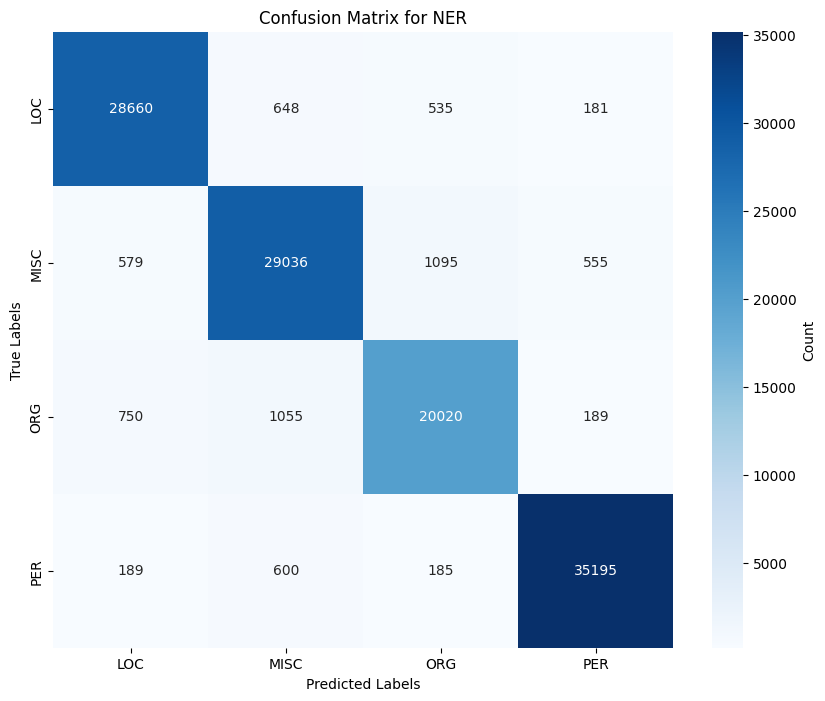

In [40]:
draw_confusion_matrix(model_preds, test_data['labels'].tolist())

Bert решает нашу задачу гораздо лучше, чем spacy. Дисбаланс в метриках между классами практически отсутствует. Категории разделяются достаточно чётко. В отличии от spacy, нет огромной разницы, между f1 и accuracy, что в совокупоности с высокими значениям recall говорит о выской способности модели находить именованные сущности.

### Weighted loss

Попробуем улучшить результаты нашей модели. Чаще всего задача NER относится к классу несбалансированных задач классификации, хотя бы потому, что токенов, не входящих ни в одну из категорий сильно больше, чем целевых классов. Попробуем уменьшить вес класса О в лоссе, для того, чтобы больше сосредоточить модель на интересующих нас категориях во время обучения.

In [38]:
%load_ext autoreload
%autoreload 2

from src.nn.validation_utils import inference

In [39]:
lr = 2e-5
weight_decay = 0.05
epochs = 3
warmup_steps = 0

In [40]:
model = create_model('distilbert/distilbert-base-cased', label_2_id)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, epochs * len(train_dataloader))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collator, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)
trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                  device=device, scheduler=scheduler, use_weighted=True)

losses = trainer.train(epochs, './bert_base_weighted')

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [18:34<00:00, 12.15it/s]

Epoch: 0, Mean loss: 0.14376491854041948



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [18:23<00:00, 12.26it/s]

Epoch: 1, Mean loss: 0.07397379249522534



raining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13531/13531 [18:38<00:00, 12.10it/s]

Epoch: 2, Mean loss: 0.04441286708355036


In [43]:
dice_model = torch.load('./bert_base_weighted/best_model.pth').to(device).eval()

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
model_preds = inference(dice_model, val_dataloader, val_data_processed['word_inds'], {v: k for k, v in label_2_id.items()}, device=device)
calculate_metrics(model_preds, test_data['labels'], metric)
None

C:\Users\Саня\AppData\Local\Temp\ipykernel_14016\1087560681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dice_model = torch.load('./bert_base_weighted/best_model.pth'

                    ORG           PER           LOC          MISC
precision      0.857349      0.954186      0.907005      0.822708
recall         0.867136      0.962293      0.933578      0.845041
f1             0.862215      0.958223      0.920100      0.833725
number     11651.000000  24717.000000  20957.000000  16798.000000 

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.895573        0.912645    0.904028          0.986128


К сожалению, улучшить метрики не получилось. Из-за большего внимания к сущностям и меньшего к O-классу появилось больше False positive примеров (упавший precision).